In [36]:
#importing libs
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import glob
from astropy.io import fits
from predict_info import *

import datetime

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Input, Conv1D, Conv1DTranspose, MaxPooling1D, UpSampling1D, Normalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, roc_curve, confusion_matrix

In [2]:
def gen_signal(N, x0, w, A, bkg, sigma, peak=False):
    x = np.arange(N)
    y = np.ones(N) * bkg
    
    if peak:
        y_peak = np.exp(-(x-x0)/w) * A
        y_peak[:x0] = 0
        y += y_peak
        
    y = np.random.poisson(y)

    return x, y

In [3]:
#random constant vales

#Number of data
N_data = 100000
df = pd.DataFrame(columns=["x0", "w", "A", "bkg", "sigma", "GRB"], index=range(N_data))

for i in range(N_data):
    df["x0"].loc[i] = np.random.randint(64, 196)
    df["w"].loc[i] = np.random.uniform(5, 15)
    df["A"].loc[i] = np.random.uniform(1, 20)
    df["bkg"].loc[i] = np.random.uniform(1, 15)
    df["GRB"].loc[i] = [True, False][np.random.randint(2)]
    
df

,x0,w,A,bkg,sigma,GRB
0,127,9.50431,14.669199,10.23924,NaN,True
1,181,5.236078,18.977249,12.784163,NaN,False
2,119,5.76446,3.946167,3.800426,NaN,False
3,82,10.505496,18.76276,6.011096,NaN,True
4,160,8.456918,8.018664,12.884299,NaN,False
...,...,...,...,...,...,...
99995,173,7.012674,9.891268,3.691995,NaN,False
99996,128,6.002221,13.388834,13.102776,NaN,True
99997,117,12.84431,6.418801,4.34267,NaN,True
99998,191,9.133706,4.315008,12.339852,NaN,True


In [4]:
#generating random data

#duration of peak window
N_tu = 256

data = []
for i in range(N_data):
    data.append(gen_signal(N=N_tu, 
                           x0=df.x0.loc[i], 
                           w=df.w.loc[i], 
                           A=df.A.loc[i], 
                           bkg=df.bkg.loc[i],
                           sigma=df.sigma.loc[i],
                           peak=df.GRB.loc[i])[1])

In [5]:
X = np.array(data).reshape(-1, N_tu)
y = df.GRB

#encode target labels with value between 0 and n_classes-1
le = LabelEncoder()

#fit label encoder
le.fit(y)

#transform labels to normalized encoding (True = 1, False = 0)
y = le.transform(y) 

#splits data into train and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Autoencoder

In [6]:
autoencoder = tf.keras.models.load_model("autoencoder_dense")

In [7]:
X_pred = autoencoder.predict(X_train)


#  Conv1D

In [8]:
model = Sequential()
model.add(Conv1D(256, 5, padding='same', activation='relu', input_shape=(np.shape(X_pred)[1], 1)))
model.add(MaxPooling1D(pool_size=8))
model.add(Conv1D(64, 5, padding='same', activation='relu'))
model.add(Flatten())
model.add(Dense(32,activation='relu'))
model.add(Dense(16,activation='relu'))
model.add(Dense(8,activation='relu'))
model.add(Dense(4,activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

conv_callback = [EarlyStopping(monitor='val_loss', patience=10),
               TensorBoard(log_dir = "./logs/conv/{}-{}-{}-{}".format(datetime.datetime.today().month,
                                                                      datetime.datetime.today().day,
                                                                      datetime.datetime.today().hour,
                                                                      datetime.datetime.today().minute), update_freq="epoch")
]
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 256, 256)          1536      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 32, 256)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 32, 64)            81984     
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 32)                65568     
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                        

In [9]:
history_conv = model.fit(X_pred, y_train,
          validation_data = (X_test, y_test),
          batch_size=64, epochs=40, callbacks=[conv_callback])

Epoch 1/40
1172/1172 [==============================] - 48s 40ms/step - loss: 0.3869 - accuracy: 0.8341 - val_loss: 4.9802 - val_accuracy: 0.5034
Epoch 2/40
1172/1172 [==============================] - 47s 40ms/step - loss: 0.2798 - accuracy: 0.8863 - val_loss: 1.2383 - val_accuracy: 0.6133
Epoch 3/40
1172/1172 [==============================] - 47s 40ms/step - loss: 0.2767 - accuracy: 0.8884 - val_loss: 1.8343 - val_accuracy: 0.5691
Epoch 4/40
1172/1172 [==============================] - 47s 40ms/step - loss: 0.2748 - accuracy: 0.8889 - val_loss: 1.0481 - val_accuracy: 0.6490
Epoch 5/40
1172/1172 [==============================] - 46s 40ms/step - loss: 0.2709 - accuracy: 0.8902 - val_loss: 1.3135 - val_accuracy: 0.6097
Epoch 6/40
1172/1172 [==============================] - 46s 39ms/step - loss: 0.2696 - accuracy: 0.8905 - val_loss: 0.5741 - val_accuracy: 0.7639
Epoch 7/40
1172/1172 [==============================] - 45s 38ms/step - loss: 0.2672 - accuracy: 0.8919 - val_loss: 0.4344 -

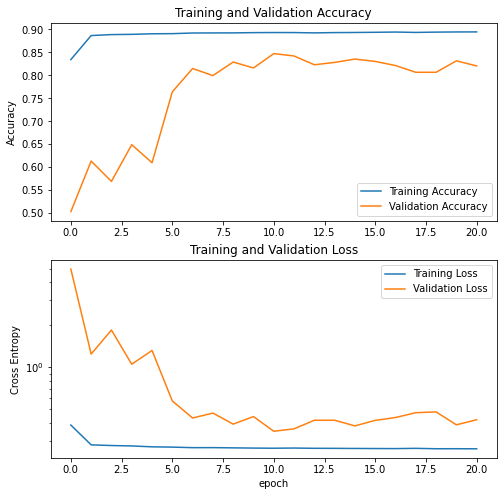

In [10]:
acc = history_conv.history['accuracy']
val_acc = history_conv.history['val_accuracy']

loss = history_conv.history['loss']
val_loss = history_conv.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.yscale("log")
plt.show()

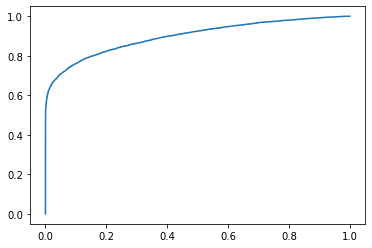

In [38]:
#ROC curve
y_pred_keras = model.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)
plt.plot(fpr_keras, tpr_keras)

True Negatives:  10441
False Positives:  2025
False Negatives:  2467
True Positives:  10067
Total:  25000


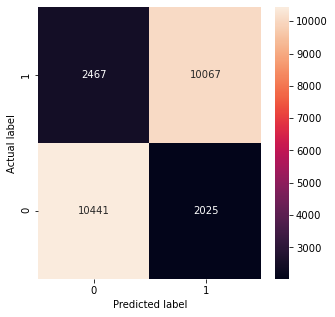

In [12]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions >= p)
    plt.figure(figsize=(5,5))
    ax = sns.heatmap(cm, annot=True, fmt="d")
    ax.invert_yaxis()
    
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('True Negatives: ', cm[0][0])
    print('False Positives: ', cm[0][1])
    print('False Negatives: ', cm[1][0])
    print('True Positives: ', cm[1][1])
    print('Total: ', np.sum(cm))
plot_cm(y_test, y_pred_keras)

(array([2016., 5269., 2982., 1587., 1054.,  848.,  626.,  673.,  704.,
        9241.]),
 array([1.7118050e-07, 1.0000015e-01, 2.0000014e-01, 3.0000013e-01,
        4.0000010e-01, 5.0000006e-01, 6.0000008e-01, 7.0000005e-01,
        8.0000001e-01, 9.0000004e-01, 1.0000000e+00], dtype=float32),
 <BarContainer object of 10 artists>)

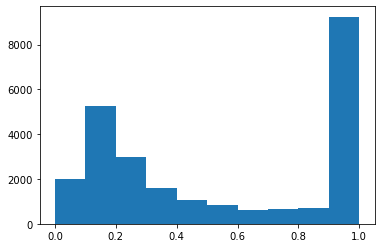

In [13]:
plt.hist(y_pred_keras)

In [17]:
model.save("conv1d_model")

INFO:tensorflow:Assets written to: conv1d_model\assets


NameError: name 'ax1' is not defined

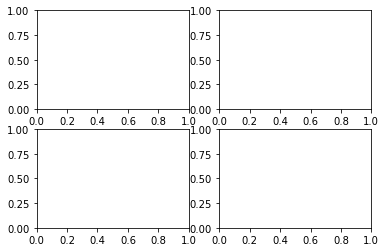

In [40]:
predict_graph_info(y_test, y_pred_keras)